In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit


def get_weights(I, thresh, p=1, canny_sigma=0):
    """
    Create pre-pixel weights based on image brightness

    Parameters
    ----------
    I: ndarray(M, N)
        Grayscale image
    thresh: float
        Amount above which to make a point 1
    p: float
        Contrast boost, apply weights^(1/p)
    
    Returns
    -------
    ndarray(M, N)
        The weights of each pixel, in the range [0, 1]
    """
    weights = np.array(I)
    if np.max(weights) > 1:
        weights /= 255
    weights = np.minimum(weights, thresh)
    weights -= np.min(weights)
    weights /= np.max(weights)
    weights = 1-weights
    weights = weights**(1/p)
    if canny_sigma > 0:
        from skimage import feature
        edges = feature.canny(I, sigma=canny_sigma)
        weights[edges > 0] = 1
    return weights


def rejection_sample_by_density(weights, target_points):
    """
    Sample points according to a particular density, by rejection sampling

    Parameters
    ----------
    ndarray(M, N)
        The weights of each pixel, in the range [0, 1]
    target_points: int
        The number of desired samples
    
    Returns
    -------
    ndarray(N, 2)
        Location of point samples
    """
    X = np.zeros((target_points, 2))
    idx = 0
    while idx < target_points:
        print(idx)
        I = np.random.rand(10*target_points)*(weights.shape[0]-1)
        J = np.random.rand(10*target_points)*(weights.shape[1]-1)
        P = np.random.rand(10*target_points)
        for i, j, p in zip(I, J, P):
            weight = weights[int(np.floor(i)), int(np.floor(j))]
            if p < weight:
                X[idx, :] = [i, j]
                idx += 1
                if idx == target_points:
                    return X
    return X

@jit(nopython=True)
def get_centroids(mask, N, weights):
    """
    Return the weighted centroids in a mask
    """
    nums = np.zeros((N, 2))
    denoms = np.zeros(N)
    for i in range(weights.shape[0]):
        for j in range(weights.shape[1]):
            idx = int(mask[i, j])
            weight = weights[i, j]
            nums[idx, 0] += weight*i
            nums[idx, 1] += weight*j
            denoms[idx] += weight
    nums = nums[denoms > 0, :]
    denoms = denoms[denoms > 0]
    return nums, denoms

def voronoi_stipple(I, thresh, target_points, p=1, canny_sigma=0, n_iters=10, do_plot=False):
    """
    An implementation of the method of [2]

    [2] Adrian Secord. Weighted Voronoi Stippling
    
    Parameters
    ----------
    I: ndarray(M, N, 3)
        An RGB/RGBA or grayscale image
    thresh: float
        Amount above which to make a point 1
    p: float
        Contrast boost, apply weights^(1/p)
    canny_sigma: float
        If >0, use a canny edge detector with this standard deviation
    n_iters: int
        Number of iterations
    do_plot: bool
        Whether to plot each iteration
    
    Returns
    -------
    ndarray(N, 2)
        An array of the stipple pattern, with x coordinates along the first
        column and y coordinates along the second column
    """
    from scipy.ndimage import distance_transform_edt
    import time
    if np.max(I) > 1:
        I = I/255
    if len(I.shape) > 2:
        I = 0.2125*I[:, :, 0] + 0.7154*I[:, :, 1] + 0.0721*I[:, :, 2]
    ## Step 1: Get weights and initialize random point distributin
    ## via rejection sampling
    weights = get_weights(I, thresh, p, canny_sigma)
    X = rejection_sample_by_density(weights, target_points)
    X = np.array(np.round(X), dtype=int)
    X[X[:, 0] >= weights.shape[0], 0] = weights.shape[0]-1
    X[X[:, 1] >= weights.shape[1], 1] = weights.shape[1]-1

    if do_plot:
        plt.figure(figsize=(10, 10))
    for it in range(n_iters):
        if do_plot:
            plt.clf()
            plt.scatter(X[:, 1], X[:, 0], 4)
            plt.gca().invert_yaxis()
            plt.xlim([0, weights.shape[1]])
            plt.ylim([weights.shape[0], 0])
            plt.savefig("Voronoi{}.png".format(it), facecolor='white')
        
        mask = np.ones_like(weights)
        X = np.array(np.round(X), dtype=int)
        mask[X[:, 0], X[:, 1]] = 0

        _, inds = distance_transform_edt(mask, return_indices=True)
        ind2num = {}
        for i in range(I.shape[0]):
            for j in range(I.shape[1]):
                coord = (inds[0, i, j], inds[1, i, j])
                if not coord in ind2num:
                    ind2num[coord] = len(ind2num)
        for i in range(I.shape[0]):
            for j in range(I.shape[1]):
                coord = (inds[0, i, j], inds[1, i, j])
                mask[i, j] = ind2num[coord]
        nums, denoms = get_centroids(mask, len(ind2num), weights)
        X = nums/denoms[:, None]
    X[:, 0] = I.shape[0]-X[:, 0]
    return np.fliplr(X)

def density_filter(X, fac, k=1):
    """
    Filter out points below a certain density

    Parameters
    ----------
    X: ndarray(N, 2)
        Point cloud
    fac: float
        Percentile (between 0 and 1) of points to keep, by density
    k: int
        How many neighbors to consider
    
    Returns
    -------
    ndarray(N)
        Distance of nearest point
    """
    from scipy.spatial import KDTree
    tree = KDTree(X)
    dd, _ = tree.query(X, k=k+1)
    dd = np.mean(dd[:, 1::], axis=1)
    q = np.quantile(dd, fac)
    return X[dd < q, :]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
0


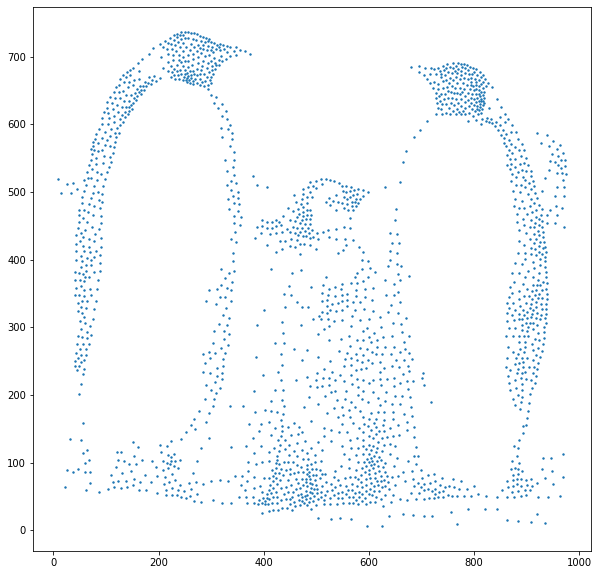

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
np.random.seed(0)
from google.colab import drive 
drive.mount("/content/drive")
# I have the images in a directory CS271/HW6/images on my google drive
I = skimage.io.imread("/content/drive/MyDrive/CS271/HW6/images/penguins.png")
# Initial stippling
X = voronoi_stipple(I, thresh=0.3, target_points=2000, canny_sigma=0.8)
# Filter out lowest 4 points by density
X = density_filter(X, (X.shape[0]-4)/X.shape[0]) 
plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], 2)
plt.savefig("penguins_stipple.svg", bbox_inches='tight')